In [537]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [621]:
DIRECTIONS = {
    "r": (1, 0),
    "rb": (1, 1),
    "b": (0, 1),
    "bl": (-1, 1),
    "l": (-1, 0),
    "lt": (-1, -1),
    "t": (0, -1),
    "tr": (1, -1),
}

def move(start, direction):
    return [x + y for x, y in zip(start, direction)]

# move(start_point, DIRECTIONS["rb"])
def get_direction(start, end):
    
    start_x, start_y = start
    end_x, end_y = end
    
    if end_x > start_x and end_y > start_y:
        directions = [DIRECTIONS["r"], DIRECTIONS["rb"], DIRECTIONS["b"]]
    elif end_x > start_x and end_y == start_y:
        directions = [DIRECTIONS["tr"], DIRECTIONS["r"], DIRECTIONS["rb"]]
    elif end_x > start_x and end_y < start_y:
        directions = [DIRECTIONS["t"], DIRECTIONS["tr"], DIRECTIONS["r"]]
    elif end_x == start_x and end_y < start_y:
        directions = [DIRECTIONS["lt"], DIRECTIONS["t"], DIRECTIONS["tr"]]
    elif end_x < start_x and end_y < start_y:
        directions = [DIRECTIONS["l"], DIRECTIONS["lt"], DIRECTIONS["t"]]
    elif end_x < start_x and end_y == start_y:
        directions = [DIRECTIONS["bl"], DIRECTIONS["l"], DIRECTIONS["lt"]]
    elif end_x < start_x and end_y > start_y:
        directions = [DIRECTIONS["b"], DIRECTIONS["bl"], DIRECTIONS["l"]]
    elif end_x == start_x and end_y > start_y:
        directions = [DIRECTIONS["rb"], DIRECTIONS["b"], DIRECTIONS["bl"]]
        
    return [move(start, direct) for direct in directions]

def __serialize(cords):
    return ",".join([str(x) for x in cords])

def __deserialize(cords_str):
    return tuple(cords_str.split(","))

def __check_valid(cords):
    return True

def add_visited(cords, visited=set()):
    cords_str = __serialize(cords)
    visited.add(cords_str)
    return visited



def filter_pos_by_minvalue(feats_array, cords):
    feats_selected = np.array([feats_array[x,y] for x, y in cords])
    # feats_selected = np.array([1,1,1])
    mask = (feats_selected == feats_selected.min())

    if mask.sum() == 1:
        next_idx = [feats_selected.argmin()]
    else:
        next_idx = [idx for idx, val in enumerate(mask) if val]
    
    return [cords[idx] for idx in next_idx]


def filter_pos_by_mindist(end, cords):
    
    rst = []
    for vec in cords:
        dist = sum([(x-y)**2 for x,y in zip(vec, end)])
        rst += [dist]
    rst = np.array(rst)
        
    mask = (rst == rst.min())

    if mask.sum() == 1:
        next_idx = [rst.argmin()]
    else:
        next_idx = [idx for idx, val in enumerate(mask) if val]
        
    return [cords[idx] for idx in next_idx]

def process_one_round(mesc, erv, current_pos, end, visited):
    next_pos = get_direction(current_pos, end)
    next_pos = [x for x in next_pos if __serialize(x) not in visited]
    next_pos = [x for x in next_pos if __check_valid(x)]
    
    for cord in next_pos:
        visited = add_visited(cord, visited=visited)
        
    if end in next_pos:
        return [end], visited
    else:
        # print("next position:", next_pos)
        if len(next_pos)>1:
            next_pos = filter_pos_by_minvalue(mesc*-1, next_pos)
            # print("MESV:")
            # print([(mesc[x][y], x, y) for x,y in next_pos])
        if len(next_pos)>1:
            next_pos = filter_pos_by_minvalue(erv, next_pos)
            # print("ERV:")
            # print([(erv[x][y], x, y) for x,y in next_pos])
        if len(next_pos)>1:
            next_pos = filter_pos_by_mindist(end, next_pos)

        return next_pos, visited
    
def __visualize(mesc, erv, path_pool):
    
    plot = np.ones_like(mesc).astype(float)
    for path in path_pool:
        l = len(path) * 4
        for idx, (row, col) in enumerate(path):
            # print(float(idx) / l, idx, l)
            plot[row, col] = float(idx) / l
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
    sns.heatmap(pd.DataFrame(plot), ax=ax0, annot=True, cbar=False)
    sns.heatmap(pd.DataFrame(mesc), ax=ax1, annot=True, cmap='YlGnBu', cbar=False)
    sns.heatmap(pd.DataFrame(erv), ax=ax2,  annot=True, cmap='Reds', cbar=False)
    
    return fig    
    
def main(mesc, erv, start, end, visualize=False):
    
    visited = add_visited(start, set())
    queue = [(start, [start], visited)]
    path_pool = []

    while queue:
        # print("queue:", [x[1] for x in queue])
        current_pos, path, visited = queue.pop(0)
        
        if current_pos == end:
            path_pool.append(path)
            continue
        
        next_pos, visited_new = process_one_round(mesc, erv, current_pos, end, visited.copy())
        for cord in next_pos:
            path_new = path.copy() + [cord]
            item = (cord, path_new, visited_new)
            queue.append(item)
    
    if visualize:
        fig = __visualize(mesc, erv, path_pool)

    return path_pool

def zoom_back(path_pool, lt):
    
    path_pool_rst = []
    for path in path_pool:
        path_pool_rst.append([[x+y for x,y in zip(cord, lt)] for cord in path])
    
    return path_pool_rst

def zoom_matrix(mesc, start, end, lt_padding=[3, 3], rb_padding=[3, 3]):
    
    lt = min(start[0], end[0]), min(start[1], end[1])
    rb = max(start[0], end[0]), max(start[1], end[1])

    lt = max(0, lt[0]-lt_padding[0]), max(0, lt[1]-lt_padding[1])
    rb = min(mesc.shape[0], rb[0]+rb_padding[0]), min(mesc.shape[1], rb[1]+rb_padding[1])

    # print(left_top, right_bottom)
    return mesc[lt[0]:rb[0], lt[1]:rb[1]], lt, rb


def fast_main(mesc, erv, start, end, visualize=False, lt_padding=[3, 3], rb_padding=[3, 3]):

    MESC_zoom, lt, _ = zoom_matrix(mesc, start, end, lt_padding, rb_padding)
    ERV_zoom, lt, _ = zoom_matrix(erv, start, end, lt_padding, rb_padding)

    start_zoom = [x-y for x,y in zip(start, lt)]
    end_zoom = [x-y for x,y in zip(end, lt)]

    path_pool_zoom = main(MESC_zoom, ERV_zoom, start_zoom, end_zoom, visualize=False)
    path_pool = zoom_back(path_pool_zoom, lt)
    
    if visualize:
        fig = __visualize(MESC, ERV, path_pool)
        
    return path_pool






In [622]:
ERV = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/案例/erv.csv").values
MESC =  pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/案例/mesc.csv").values

### 开始测试

✅ 案例一

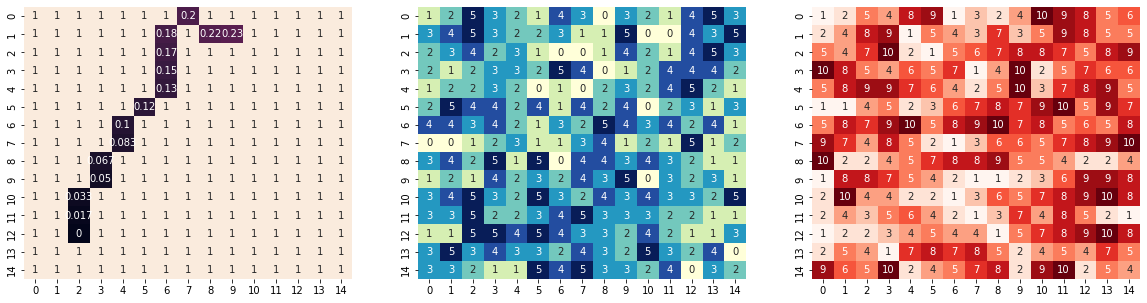

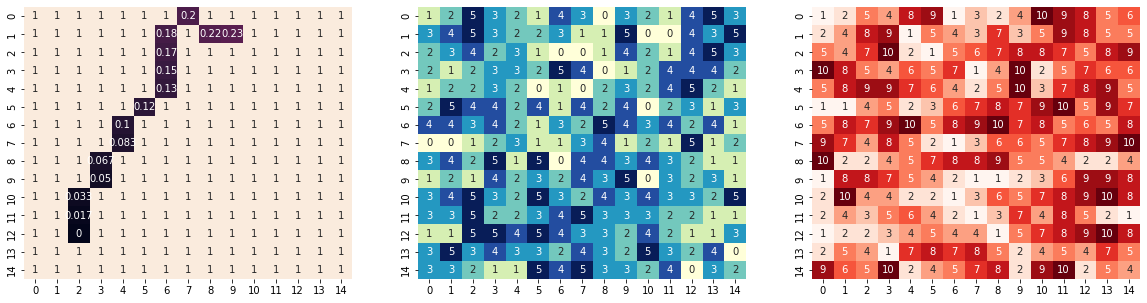

In [624]:
start = [12, 2]
end = [1, 9]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)

✅ 案例二

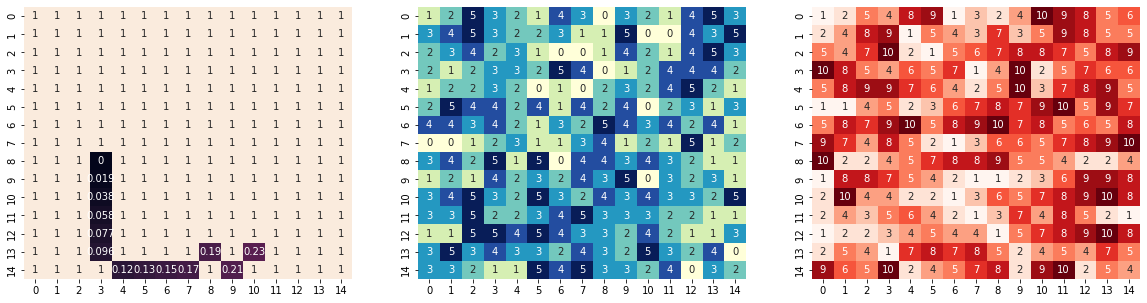

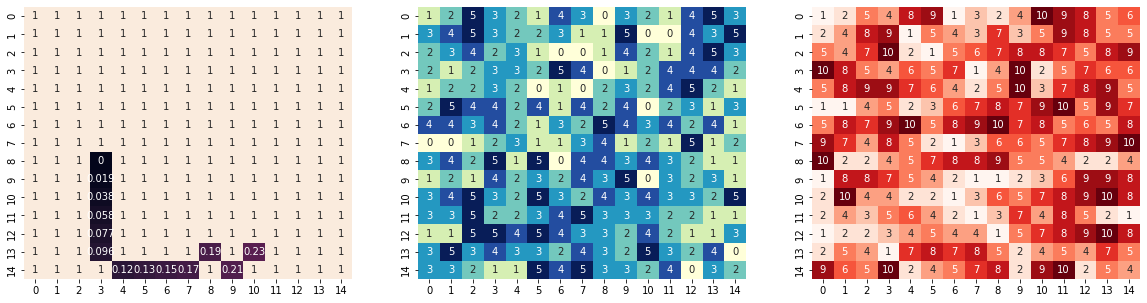

In [625]:
start = [8, 3]
end = [13, 10]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)

✅ 案例三

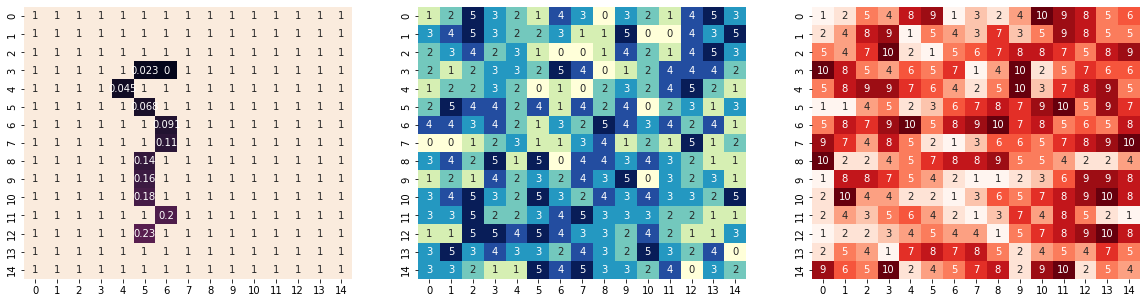

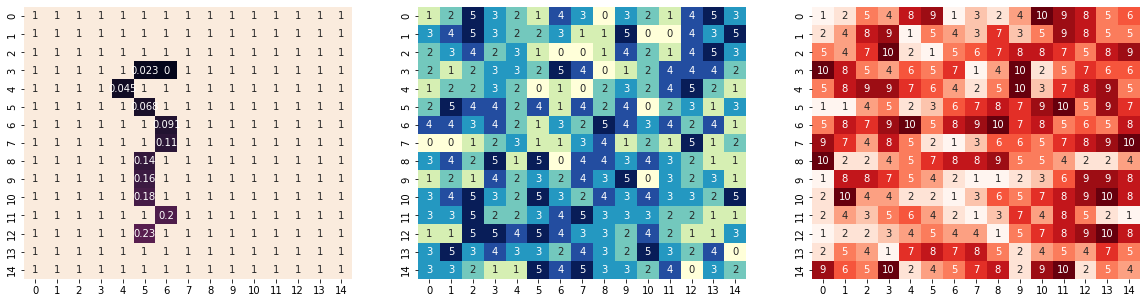

In [626]:
start = [3, 6]
end = [12, 5]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)


✅ 案例四

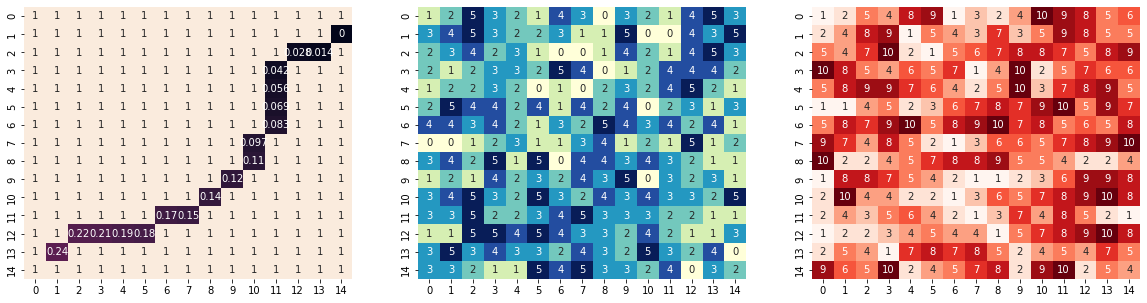

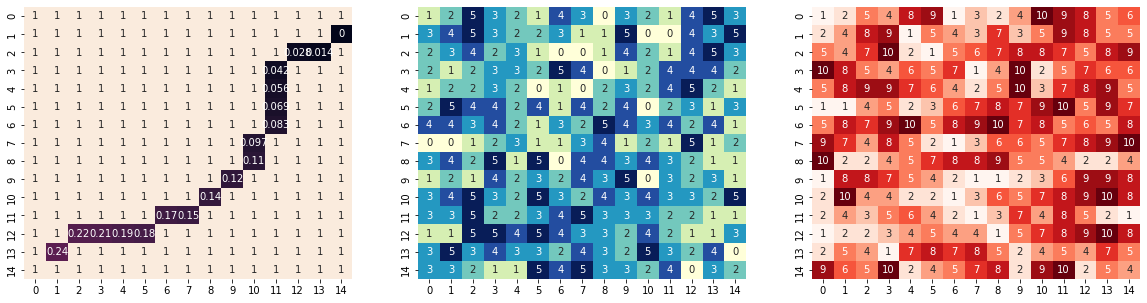

In [627]:
start = [1, 14]
end = [13, 1]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)


✅ 案例五

In [632]:
start = [11, 7]
end = [3, 7]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)

✅ 案例六

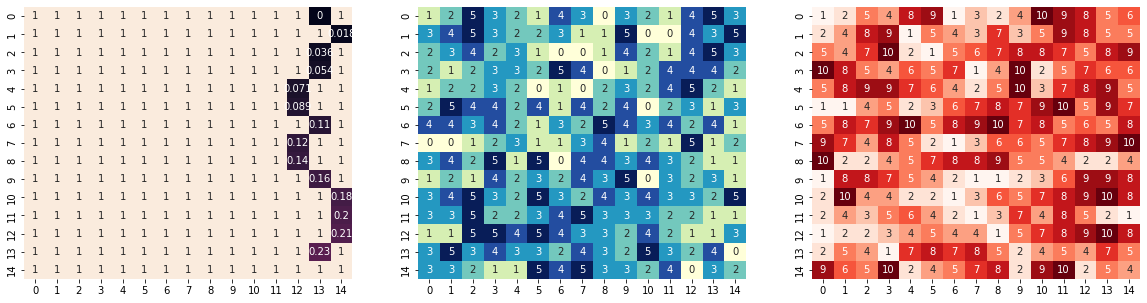

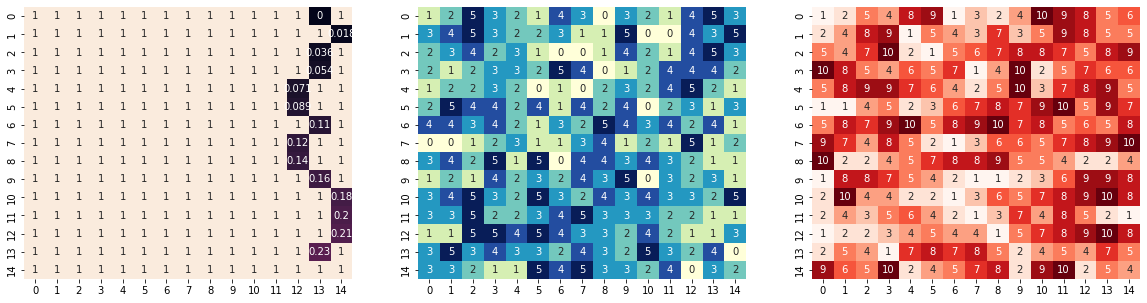

In [629]:
start = [0, 13]
end = [13, 13]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)


✅ 案例七

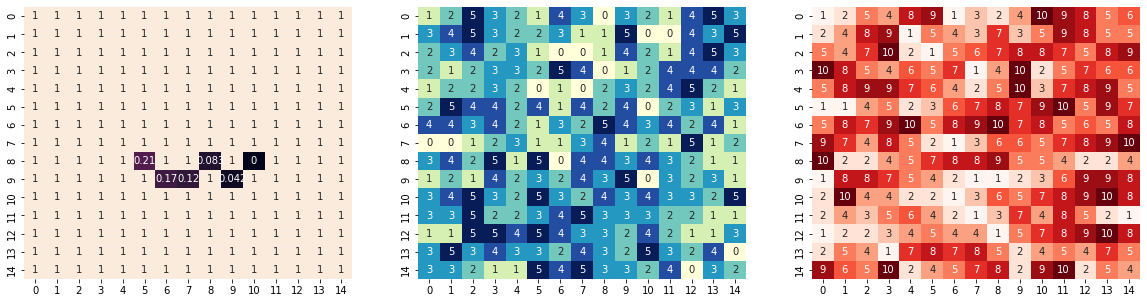

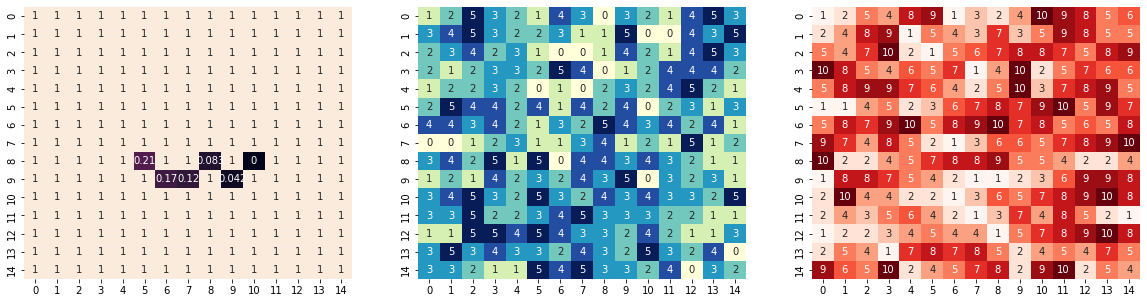

In [630]:
start = [8, 10]
end = [8, 5]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)


✅ 案例八

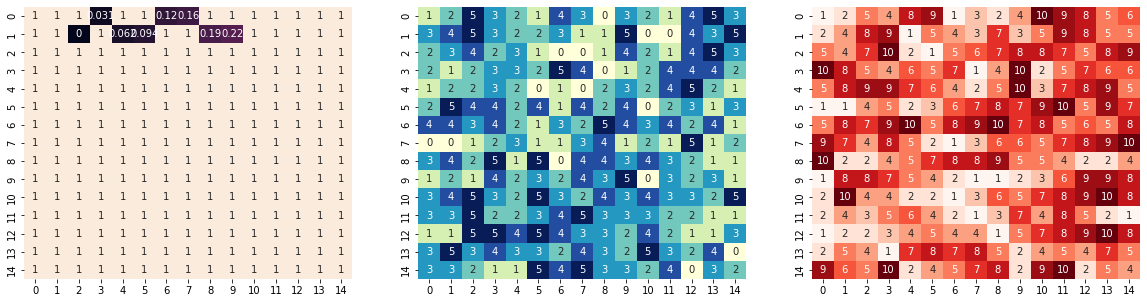

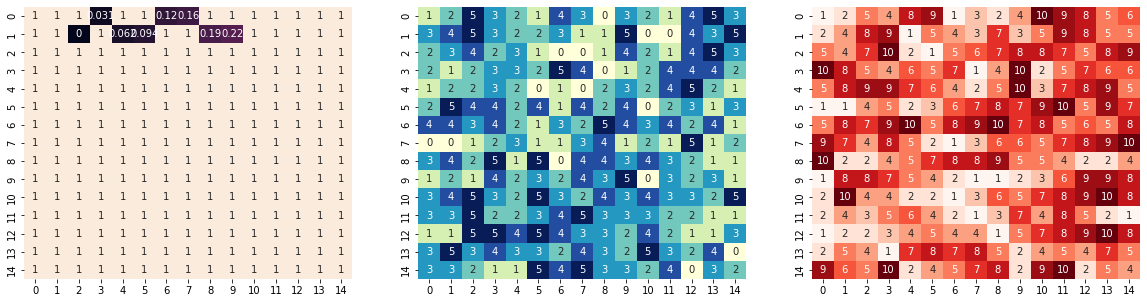

In [631]:
start = [1, 2]
end = [1, 9]
path_pool = main(MESC, ERV, start, end, visualize=True)
path_pool = fast_main(MESC, ERV, start, end, visualize=True)


### 自己造一些返回多个点案例

#### 测试是不是返回两条路径

In [321]:
np.random.seed(2022)

size = 25
random_sample = np.random.randint(low=0, high=5, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
MESC = random_sample

random_sample = np.random.randint(low=0, high=10, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
ERV = random_sample



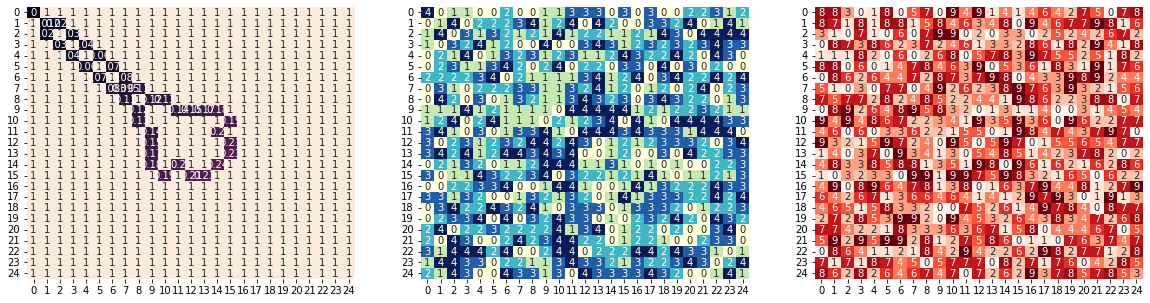

In [322]:
start = [0, 0]
end = [14, 14]
path_pool = main(MESC, ERV, start, end, visualize=True)

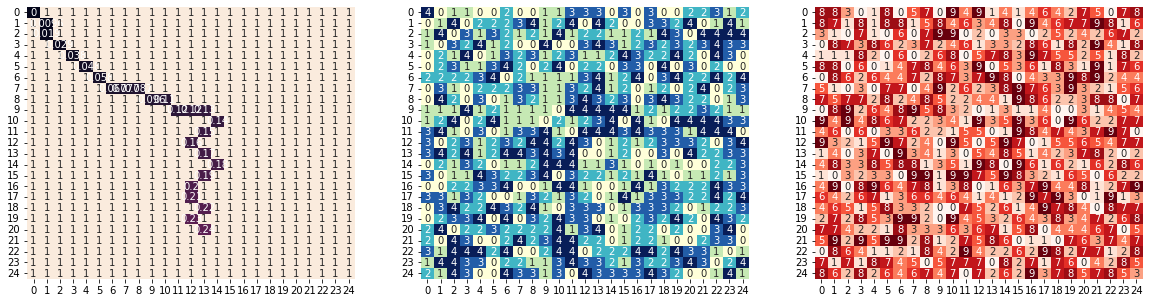

In [324]:
start = [0, 0]
end = [20, 13]
path_pool = main(MESC, ERV, start, end, visualize=True)

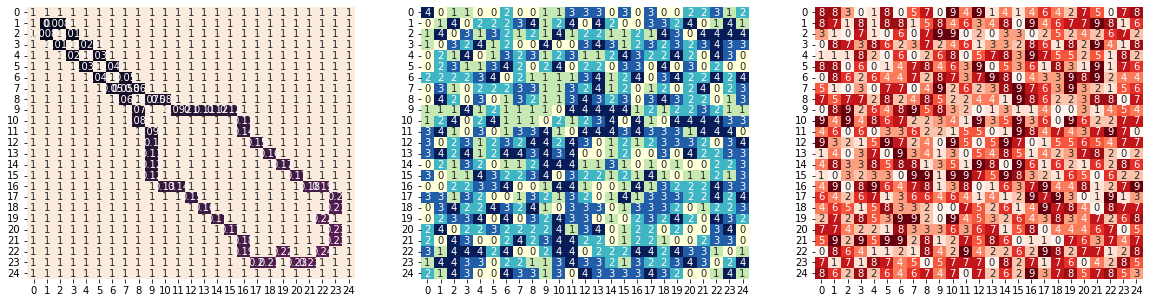

In [326]:
start = [1, 1]
end = [22, 22]
path_pool = main(MESC, ERV, start, end, visualize=True)

#### 测试一下运行速度

In [361]:
np.random.seed(2022)

size = 5000
random_sample = np.random.randint(low=0, high=5, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
MESC = random_sample

random_sample = np.random.randint(low=0, high=10, size=size**2).reshape(size, size)
random_sample = np.triu(random_sample)
random_sample += random_sample.T - np.diag(random_sample.diagonal())
ERV = random_sample

In [362]:
start = [0, 0]
end = [3800, 4300]
end_idx = int(1.1*max(end))

mesc = MESC[:end_idx, :end_idx]
erv = ERV[:end_idx, :end_idx]

path_pool = main(mesc, erv, start, end, visualize=False)

KeyboardInterrupt: 

In [343]:
start = [0, 0]
end = [200, 100]
path_pool = main(MESC, ERV, start, end, visualize=False)

In [359]:
len(path_pool)

2

### 实际情况应用

In [481]:
def get_data_from_tif(file_path):
    
    from osgeo import gdal

    gdal.AllRegister()

    dataset = gdal.Open(file_path)
    nXSize = dataset.RasterXSize 
    nYSize = dataset.RasterYSize 
    nBands = dataset.RasterCount

    im_data = dataset.ReadAsArray(0,0,nXSize,nYSize)
    adfGeoTransform = dataset.GetGeoTransform()
    
    return im_data, adfGeoTransform, nXSize, nYSize, nBands
    
ECR, adfGeoTransform, nXSize, nYSize, nBands = get_data_from_tif(r'/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/ECR_values_10ranks1.tif')
MESC, _, _, _, _ = get_data_from_tif(r'/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/MESC_of_NS_Agri_Cons2.tif')

In [496]:
points_of_interests = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/关注的节点编号及XY坐标.csv")
points_of_interests = pd.DataFrame(np.concatenate([points_of_interests[["start", "start X", "start Y"]].values, points_of_interests[["end", "end X", "end Y"]].values], axis=0))
points_of_interests.columns = ["idx", "X", "Y"]
points_of_interests = points_of_interests.drop_duplicates().astype(float).reset_index(drop=True)
points_of_interests["left_top_X"] = adfGeoTransform[0]
points_of_interests["left_top_Y"] = adfGeoTransform[3]
points_of_interests["nY"] = ((points_of_interests["X"] - points_of_interests["left_top_X"]) / adfGeoTransform[1]).astype(int)
points_of_interests["nX"] = ((points_of_interests["Y"] - points_of_interests["left_top_Y"]) / adfGeoTransform[5]).astype(int)
points_of_interests

mapping_dict = {}
for idx, row in points_of_interests.iterrows():
    mapping_dict[int(row["idx"])] = [row["nX"], row["nY"]]
    
points_of_interests = pd.read_csv("/Users/tuanzai/Desktop/Canada/001.UBC/block_capstone/花姐项目/simple_landscape_analysis/history/2.4.4/实际/关注的节点编号及XY坐标.csv")


In [503]:
final_input = points_of_interests[["rank", "start", "end"]].astype(int)
final_input["start_cord"] = final_input["start"].map(mapping_dict) 
final_input["end_cord"] = final_input["end"].map(mapping_dict) 

final_input

,rank,start,end,start_cord,end_cord
0,1,10,23,"[2129.0, 4315.0]","[2178.0, 4578.0]"
1,2,30,31,"[3445.0, 4636.0]","[3471.0, 4447.0]"
2,3,29,30,"[3434.0, 4827.0]","[3445.0, 4636.0]"
3,4,25,26,"[2760.0, 4922.0]","[2880.0, 5073.0]"
4,5,12,27,"[2922.0, 4583.0]","[3084.0, 4311.0]"
5,6,9,21,"[1588.0, 4120.0]","[1868.0, 4031.0]"
6,7,30,33,"[3445.0, 4636.0]","[3720.0, 4632.0]"
7,8,34,35,"[3798.0, 4532.0]","[4028.0, 4452.0]"
8,9,10,21,"[2129.0, 4315.0]","[1868.0, 4031.0]"
9,10,31,33,"[3471.0, 4447.0]","[3720.0, 4632.0]"


im_bands = dataset.RasterCount